<h1>Visualizations of results from modeltesting</h1>

In [18]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

df = pd.read_csv('results/avg_results.csv')
df_results = pd.read_csv('results/results.csv')
averaged_df = df.groupby('Model', as_index=False)[['Average time[s]', 'Average tokens/s']].mean()

lang_error_dict = {}

lang_counts = df[df['Inteded purpose'] == 'coding']['Language errors'].value_counts()
lang_error = df_results['results'].str.split(',').reset_index(drop=True)

for lang_list in lang_error:
    for lang in lang_list:
        if lang not in lang_error_dict:
            lang_error_dict[lang] = 0
        lang_error_dict[lang] += 1
        

# Retrieve language with most errors
max_index = max(lang_error_dict, key=lang_error_dict.get)
colors = ['#00A77E',] * len(lang_error_dict)
max_pos = list(lang_error_dict.keys()).index(max_index)
colors[max_pos] = 'lightslategray'

# Count number models with atleast one appearence of each language
lang_occurences = {}
models = os.listdir('output')
for model in models:
    path = Path('output') / model
    code_snippets = os.listdir(path)
    languages_in_model = set()
    for code_snippet in code_snippets:
        if code_snippet.endswith('go'):
            lang = 'go'
            go_codes = os.listdir(path / code_snippet)
            for go_code in go_codes:
                if lang not in lang_occurences:
                    lang_occurences[lang] = 0
                if lang not in languages_in_model:
                    languages_in_model.add(lang)
                    lang_occurences[lang] += 1
        else:
            lang = code_snippet.split('.')[1]
            if lang not in lang_occurences:
                lang_occurences[lang] = 0
            if lang not in languages_in_model:
                languages_in_model.add(lang)
                lang_occurences[lang] += 1


# Plot total models containing language vs models with language errors
fig = go.Figure()

fig.add_trace(go.Bar(
    x=list(lang_occurences.keys()),
    y=list(lang_occurences.values()),
    name='Total Occurrences',
    hovertemplate='Language: %{x}<br>Total: %{y}<extra></extra>',
    marker_color='lightslategray'
))

fig.add_trace(go.Bar(
    x=list(lang_error_dict.keys()),
    y=list(lang_error_dict.values()),
    name='Models with Language Errors',
    hovertemplate='Language: %{x}<br>Containing errors: %{y}<extra></extra>',
    marker_color='#00A77E'
))

fig.update_layout(
    barmode='overlay',
    xaxis_title='Language',
    yaxis_title='Number of Models',
    title='Total occurrences vs Language Errors in Models',
    width=1000,
    height=600
)
fig.show()
fig.write_html('results/language_errors.html')


> *Note*: Java will almost always contain 'syntax-errors', due to its strict syntax rules. It will not compile if for instance a class is defined, but the file is not named after the class. This is not inheritently a problem with the model, but rather a limitation of syntax-checking the language itself.

In [19]:
# Plot of Average Time[s] and Average Tokens/s

fig = px.scatter(
    averaged_df,
    x='Average time[s]',
    y='Average tokens/s',
    hover_name='Model',
    color='Model',
)
fig.update_traces(marker=dict(size=12, opacity=0.7))
fig.show()
fig.write_html('results/avg_time_tokens.html')

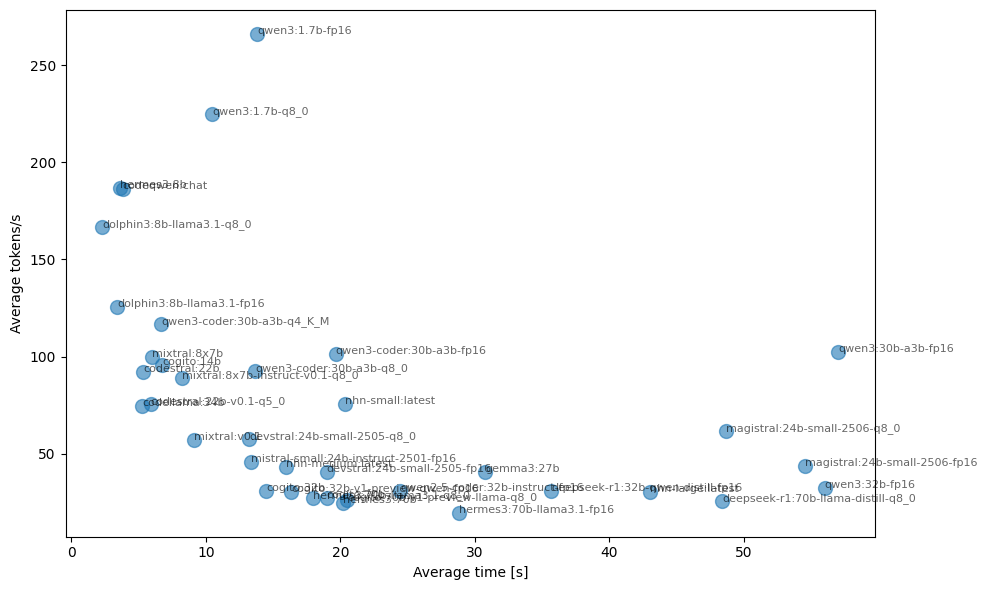

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(
    averaged_df['Average time[s]'],
    averaged_df['Average tokens/s'],
    s=100, alpha=0.6
)

for i, row in averaged_df.iterrows():
    ax.text(
        row['Average time[s]'],
        row['Average tokens/s'],
        row['Model'],
        fontsize=8,
        alpha=0.6
    )

ax.set_xlabel('Average time [s]')
ax.set_ylabel('Average tokens/s')
plt.tight_layout()
plt.show()
